In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/LLM Project/')

In [ ]:
from transformer import Transformer
import torch
import numpy as np|


In [3]:
english_file = '/content/drive/MyDrive/LLM Project/dataset/train.en'
Hindi_file = '/content/drive/MyDrive/LLM Project/dataset/train.hi'

# Generated this by filtering Appendix code

START_TOKEN = '<START>'
PADDING_TOKEN = '<PADDING>'
END_TOKEN = '<END>'

Hindi_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ',
                    'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ',
                    'क', 'ख', 'ग', 'घ', 'ङ',
                    'च', 'छ', 'ज', 'झ', 'ञ',
                    'ट', 'ठ', 'ड', 'ढ', 'ण',
                    'त', 'थ', 'द', 'ध', 'न',
                    'प', 'फ', 'ब', 'भ', 'म',
                    'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह',
                    'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्',
                    'ॐ', '॒', '॓', '॔', '।', '॥',
                    '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', PADDING_TOKEN, END_TOKEN]


english_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~', PADDING_TOKEN, END_TOKEN]

In [4]:
index_to_Hindi = {k:v for k,v in enumerate(Hindi_vocabulary)}
Hindi_to_index = {v:k for k,v in enumerate(Hindi_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

In [54]:
with open(english_file, 'r') as file:
    english_sentences = file.readlines()
with open(Hindi_file, 'r', encoding='utf-8') as file:
    Hindi_sentences = file.readlines()

# Limit Number of sentences
TOTAL_SENTENCES = 2000000
english_sentences = english_sentences[:TOTAL_SENTENCES]
Hindi_sentences = Hindi_sentences[:TOTAL_SENTENCES]
english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
Hindi_sentences = [sentence.rstrip('\n') for sentence in Hindi_sentences]

In [55]:
english_sentences[:10]

["however, paes, who was partnering australia's paul hanley, could only go as far as the quarterfinals where they lost to bhupathi and knowles",
 'whosoever desires the reward of the world, with allah is the reward of the world and of the everlasting life. allah is the hearer, the seer.',
 'the value of insects in the biosphere is enormous because they outnumber all other living groups in measure of species richness.',
 'mithali to anchor indian team against australia in odis',
 'after the assent of the honble president on 8thseptember, 2016, the 101thconstitutional amendment act, 2016 came into existence',
 'the court has fixed a hearing for february 12',
 'please select the position where the track should be split.',
 'as per police, armys 22rr, special operation group (sog) of police and the central reserve police force (crpf) cordoned the village and launched search operation in the area.',
 'jharkhand chief minister hemant soren',
 'arvind kumar, sho of the sector 55/56 police sta

In [56]:
Hindi_sentences[:10]

['आस्ट्रेलिया के पाल हेनली के साथ जोड़ी बनाने वाले पेस मियामी में क्वार्टरफाइनल तक ही पहुंच सके क्योंकि इस दौर में उन्हें भूपति और नोल्स ने हराया था।',
 'और जो शख्स (अपने आमाल का) बदला दुनिया ही में चाहता है तो ख़ुदा के पास दुनिया व आख़िरत दोनों का अज्र मौजूद है और ख़ुदा तो हर शख्स की सुनता और सबको देखता है',
 'जैव-मंडल में कीड़ों का मूल्य बहुत है, क्योंकि प्रजातियों की समृद्धि के मामले में उनकी संख्या अन्य जीव समूहों से ज़्यादा है।',
 'आस्ट्रेलिया के खिलाफ वनडे टीम की कमान मिताली को',
 '8 सितम्\u200dबर, 2016 को माननीय राष्\u200dट्रपति की स्\u200dवीकृति मिलने के बाद 101वां संविधान संशोधन अधिनियम, 2016 अस्तित्\u200dव में आया',
 'अदालत ने इस मामले में आगे की सुनवाई के लिए एक फरवरी की तारीख़ तय की',
 'जहाँ पर ट्रैक को विभाजित किया जाना है, कृपया वह स्थान चुनें.',
 'इसके तुरंत बाद सेना की 22 राष्ट्रीय राइफल्स (आरआर), सीआरपीएफ और पुलिस के स्पेशल ऑपरेशन ग्रुप (एसओजी) के जवानों द्वारा इलाके की घेराबंदी कर तलाशी अभियान चलाया।',
 'झारखंड के मुख्यमंत्री हेमंत सोरेन (फोटोः पीटीआई)',
 'सेक्टर 55/56

In [57]:
import numpy as np
PERCENTILE = 97
print( f"{PERCENTILE}th percentile length Hindi: {np.percentile([len(x) for x in Hindi_sentences], PERCENTILE)}" )
print( f"{PERCENTILE}th percentile length English: {np.percentile([len(x) for x in english_sentences], PERCENTILE)}" )


97th percentile length Hindi: 259.0
97th percentile length English: 268.0


In [58]:
max_sequence_length = 270

def is_valid_tokens(sentence, vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

def is_valid_length(sentence, max_sequence_length):
    return len(list(sentence)) < (max_sequence_length - 1)

valid_sentence_indicies = []
for index in range(len(Hindi_sentences)):
    Hindi_sentence, english_sentence = Hindi_sentences[index], english_sentences[index]
    if is_valid_length(Hindi_sentence, max_sequence_length) \
      and is_valid_length(english_sentence, max_sequence_length) \
      and is_valid_tokens(Hindi_sentence, Hindi_vocabulary):
        valid_sentence_indicies.append(index)

print(f"Number of sentences: {len(Hindi_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of sentences: 2000000
Number of valid sentences: 1278881


In [59]:
Hindi_sentences = [Hindi_sentences[i] for i in valid_sentence_indicies]
english_sentences = [english_sentences[i] for i in valid_sentence_indicies]

In [60]:
Hindi_sentences[:3]

['आस्ट्रेलिया के खिलाफ वनडे टीम की कमान मिताली को',
 'जहाँ पर ट्रैक को विभाजित किया जाना है, कृपया वह स्थान चुनें.',
 'इसके तुरंत बाद सेना की 22 राष्ट्रीय राइफल्स (आरआर), सीआरपीएफ और पुलिस के स्पेशल ऑपरेशन ग्रुप (एसओजी) के जवानों द्वारा इलाके की घेराबंदी कर तलाशी अभियान चलाया।']

In [61]:
import torch

d_model = 512
batch_size = 30
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 1
max_sequence_length = 270
hi_vocab_size = len(Hindi_vocabulary)

transformer = Transformer(d_model,
                          ffn_hidden,
                          num_heads,
                          drop_prob,
                          num_layers,
                          max_sequence_length,
                          hi_vocab_size,
                          english_to_index,
                          Hindi_to_index,
                          START_TOKEN,
                          END_TOKEN,
                          PADDING_TOKEN)

In [62]:
transformer

Transformer(
  (encoder): Encoder(
    (sentence_embedding): SentenceEmbedding(
      (embedding): Embedding(71, 512)
      (position_encoder): PositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): SequentialEncoder(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (qkv_layer): Linear(in_features=512, out_features=1536, bias=True)
          (linear_layer): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNormalization()
        (dropout1): Dropout(p=0.1, inplace=False)
        (ffn): PositionwiseFeedForward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNormalization()
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (sentence_embedding):

In [63]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, english_sentences, Hindi_sentences):
        self.english_sentences = english_sentences
        self.Hindi_sentences = Hindi_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.Hindi_sentences[idx]

In [64]:
dataset = TextDataset(english_sentences, Hindi_sentences)

In [65]:
len(dataset)

1278881

In [66]:
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

In [67]:
for batch_num, batch in enumerate(iterator):
    print(batch)
    if batch_num > 3:
        break

[('mithali to anchor indian team against australia in odis', 'please select the position where the track should be split.', 'as per police, armys 22rr, special operation group (sog) of police and the central reserve police force (crpf) cordoned the village and launched search operation in the area.', 'jharkhand chief minister hemant soren', 'arvind kumar, sho of the sector 55/56 police station, said a case has been registered under section 376-d (gang rape) of the indian penal code.', "briefing media in new delhi today, party's state-in-charge, anil jain said, after the meeting the party will meet the governor to stake claim for government formation in the state.", '"jesus responded, as he taught in the temple, ""how is it that the scribes say that the christ is the son of david?"', 'senior leaders of all major parties held electioneering in favour of their candidates.', 'meanwhile, three people came there on a bike.', 'he does this because he is angry at the alleged desecration of the

In [68]:
from torch import nn

criterian = nn.CrossEntropyLoss(ignore_index=Hindi_to_index[PADDING_TOKEN],
                                reduction='none')

for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [69]:
NEG_INFTY = -1e9

def create_masks(eng_batch, hi_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
      eng_sentence_length, hi_sentence_length = len(eng_batch[idx]), len(hi_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
      hi_chars_to_padding_mask = np.arange(hi_sentence_length + 1, max_sequence_length)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, hi_chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, hi_chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, hi_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [84]:
transformer.train()
transformer.to(device)
total_loss = 0
num_epochs = 12
train_losses=[]

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, hi_batch = batch
        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch, hi_batch)
        optim.zero_grad()
        hi_predictions = transformer(eng_batch,
                                     hi_batch,
                                     encoder_self_attention_mask.to(device),
                                     decoder_self_attention_mask.to(device),
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=True)
        labels = transformer.decoder.sentence_embedding.batch_tokenize(hi_batch, start_token=False, end_token=True)
        loss = criterian(
            hi_predictions.view(-1, hi_vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == Hindi_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()
        train_losses.append(loss.item())
        if batch_num % 100 == 0:
            print(f"Iteration {batch_num} : Loss {loss.item()}")



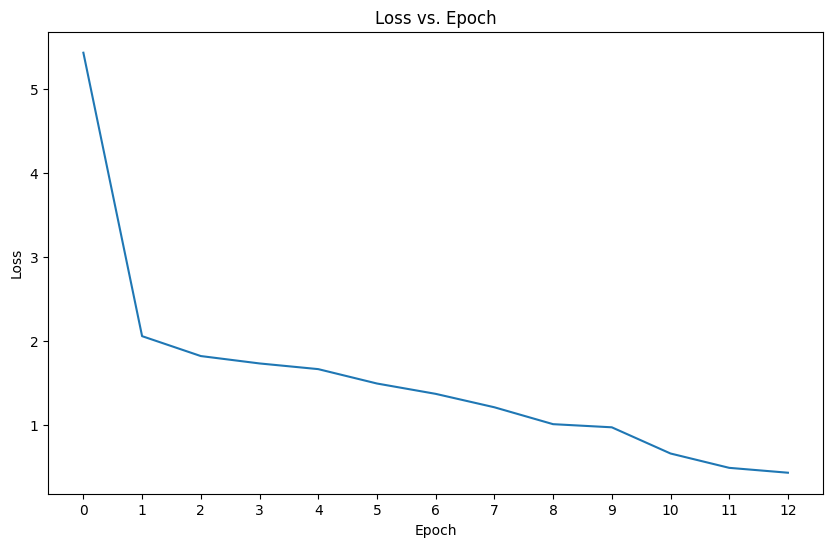

In [96]:
import matplotlib.pyplot as plt

# Plot the loss vs. epoch
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()


In [72]:
# @title
transformer.eval()
def translate(eng_sentence):
  eng_sentence = (eng_sentence,)
  hi_sentence = ("",)
  for word_counter in range(max_sequence_length):
    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, hi_sentence)
    predictions = transformer(eng_sentence,
                              hi_sentence,
                              encoder_self_attention_mask.to(device),
                              decoder_self_attention_mask.to(device),
                              decoder_cross_attention_mask.to(device),
                              enc_start_token=False,
                              enc_end_token=False,
                              dec_start_token=True,
                              dec_end_token=False)
    next_token_prob_distribution = predictions[0][word_counter]
    next_token_index = torch.argmax(next_token_prob_distribution).item()
    next_token = index_to_Hindi[next_token_index]
    hi_sentence = (hi_sentence[0] + next_token, )
    if next_token == END_TOKEN:
      break
  return hi_sentence[0]

In [98]:
translation = translate("what should we do when the day starts?")
print(translation)


दिन शुरु पर हम क्या करन चाहिए?


In [99]:
translation = translate("how is this the truth?")
print(translation)


यह सच है कैसे?


In [100]:
translation = translate("i cannot stand this smell")
print(translation)


मैं यह गंध सहन नहीं होती।


In [101]:
translation = translate("click this")
print(translation)

क्लिक करें।


In [102]:
translation = translate("I am right here")
print(translation)


मैं इसी जगह हूँ।
